In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchvision, torch

In [3]:
#import torchsummary

In [4]:
#import hiddenlayer as hl

In [63]:
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
from skimage.metrics import structural_similarity
from scipy.stats import spearmanr as spr, pearsonr
#from skimage import measure
#from skimage.metrics import structural_similarity
from skimage import feature

%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil
import json
import glob
from cascading_randomization_utils import *

In [10]:
# loading data
dmerge = datasets.get_data("nih")

# loading models
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()
models = [xrv.models.DenseNet(weights="all").cuda(),
          xrv.baseline_models.jfhealthcare.DenseNet().cuda()]
models_toreset = [xrv.models.DenseNet(weights="all").cuda(),
                  xrv.baseline_models.jfhealthcare.DenseNet().cuda()]

NIH_Dataset num_samples=67310 views=['PA'] data_aug=None


In [77]:
model = models[0]
model_toreset=models_toreset[0]
print(model.pathologies)
print(model,model_toreset)

['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
XRV-DenseNet121-all XRV-DenseNet121-all


In [74]:
# display hierarchical structure of this model up to level of detail
# these keys can be used to specify which part to reset
sd=model.state_dict()
last_item=''
for k,v in sd.items():
    A=k.split('.')
    limit=2
    if len(A)>2 and 'dense' in A[2]:
        limit=3
    S=".".join(A[:min(len(A),limit)] + (['*'] if len(A)>limit else []))
    if S!=last_item:
        print(S)
        last_item=S
    #print(k,type(v))


op_threshs
features.conv0.*
features.norm0.*
features.denseblock1.denselayer1.*
features.denseblock1.denselayer2.*
features.denseblock1.denselayer3.*
features.denseblock1.denselayer4.*
features.denseblock1.denselayer5.*
features.denseblock1.denselayer6.*
features.transition1.*
features.denseblock2.denselayer1.*
features.denseblock2.denselayer2.*
features.denseblock2.denselayer3.*
features.denseblock2.denselayer4.*
features.denseblock2.denselayer5.*
features.denseblock2.denselayer6.*
features.denseblock2.denselayer7.*
features.denseblock2.denselayer8.*
features.denseblock2.denselayer9.*
features.denseblock2.denselayer10.*
features.denseblock2.denselayer11.*
features.denseblock2.denselayer12.*
features.transition2.*
features.denseblock3.denselayer1.*
features.denseblock3.denselayer2.*
features.denseblock3.denselayer3.*
features.denseblock3.denselayer4.*
features.denseblock3.denselayer5.*
features.denseblock3.denselayer6.*
features.denseblock3.denselayer7.*
features.denseblock3.denselayer

In [98]:
def weight_randomizer(model,key):
    #print("Reinitializing",key)
    keylist=key.split('.')
    M=model
    for k in keylist:
        M=M._modules[k]
    for i,m in enumerate(M.modules()):
        if isinstance(m, torch.nn.Conv2d):
            #print(f"===================================== {i} ==============================")
            #print(m)
            print("----Conv2d")
            m.reset_parameters()
            #torch.nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, torch.nn.BatchNorm2d):
            #print(f"===================================== {i} ==============================")
            #print(m)
            print("----BatchNorm2d")
            m.reset_parameters()
            #torch.nn.init.constant_(m.weight, 1)
            #torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.Linear):
            #print(f"===================================== {i} ==============================")
            #print(m)
            print("----Linear")
            m.reset_parameters()
            #torch.nn.init.kaiming_normal_(m.weight)
            #torch.nn.init.constant_(m.bias, 0)


In [79]:
for_eval = [
            "Cardiomegaly",
            "Atelectasis",
            "Effusion",
            "Consolidation",
            "Edema",
            "Mass"
            ]

In [80]:
model.pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [81]:
for_eval

['Cardiomegaly', 'Atelectasis', 'Effusion', 'Consolidation', 'Edema', 'Mass']

In [99]:
class ModelWrapper(object):
    def __init__(self, model):
        self.model = model
        
##    def predict(self, batch):
##        return self.model.forward(batch)
    def reinit_layer_by_key(self, key, verbose=False):
        keylist=key.split('.')
        M=self.model
        for k in keylist:
            M=M._modules[k]
        for i,m in enumerate(M.modules()):
            if isinstance(m, torch.nn.Conv2d):
                #print(f"===================================== {i} ==============================")
                #print(m)
                if verbose:
                    print("----Conv2d")
                m.reset_parameters()
                #torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, torch.nn.BatchNorm2d):
                #print(f"===================================== {i} ==============================")
                #print(m)
                if verbose:
                    print("----BatchNorm2d")
                m.reset_parameters()
                #torch.nn.init.constant_(m.weight, 1)
                #torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                #print(f"===================================== {i} ==============================")
                #print(m)
                if verbose:
                    print("----Linear")
                m.reset_parameters()
                #torch.nn.init.kaiming_normal_(m.weight)
                #torch.nn.init.constant_(m.bias, 0)
            else:
                #print(f"===================================== {i} ==============================")
                #print(m)
                if verbose:
                    print("----Ignoring",type(m))
                #torch.nn.init.kaiming_normal_(m.weight)
                #torch.nn.init.constant_(m.bias, 0)

    def reinit_layer_at_index(self, layer_nb:int):
        """Reinitialize Tensors with this index."""
        M = list(self.model.modules())[layer_nb]
        for i,m in enumerate(M.modules()):
            if isinstance(m, torch.nn.Conv2d):
                #print(f"===================================== {i} ==============================")
                #print(m)
                print("----Conv2d")
                m.reset_parameters()
                #torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, torch.nn.BatchNorm2d):
                #print(f"===================================== {i} ==============================")
                #print(m)
                print("----BatchNorm2d")
                m.reset_parameters()
                #torch.nn.init.constant_(m.weight, 1)
                #torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                #print(f"===================================== {i} ==============================")
                #print(m)
                print("----Linear")
                m.reset_parameters()
                #torch.nn.init.kaiming_normal_(m.weight)
                #torch.nn.init.constant_(m.bias, 0)
            else:
                #print(f"===================================== {i} ==============================")
                #print(m)
                print("----Ignoring",type(m))
                #torch.nn.init.kaiming_normal_(m.weight)
                #torch.nn.init.constant_(m.bias, 0)

In [25]:
methods = ["grad", "guided", "integrated", "latentshift-max"]


In [12]:
temp_path = "/carl/rupert_brooks/output/temp"

tensor([0.5100])
[0.44826764] -370 20


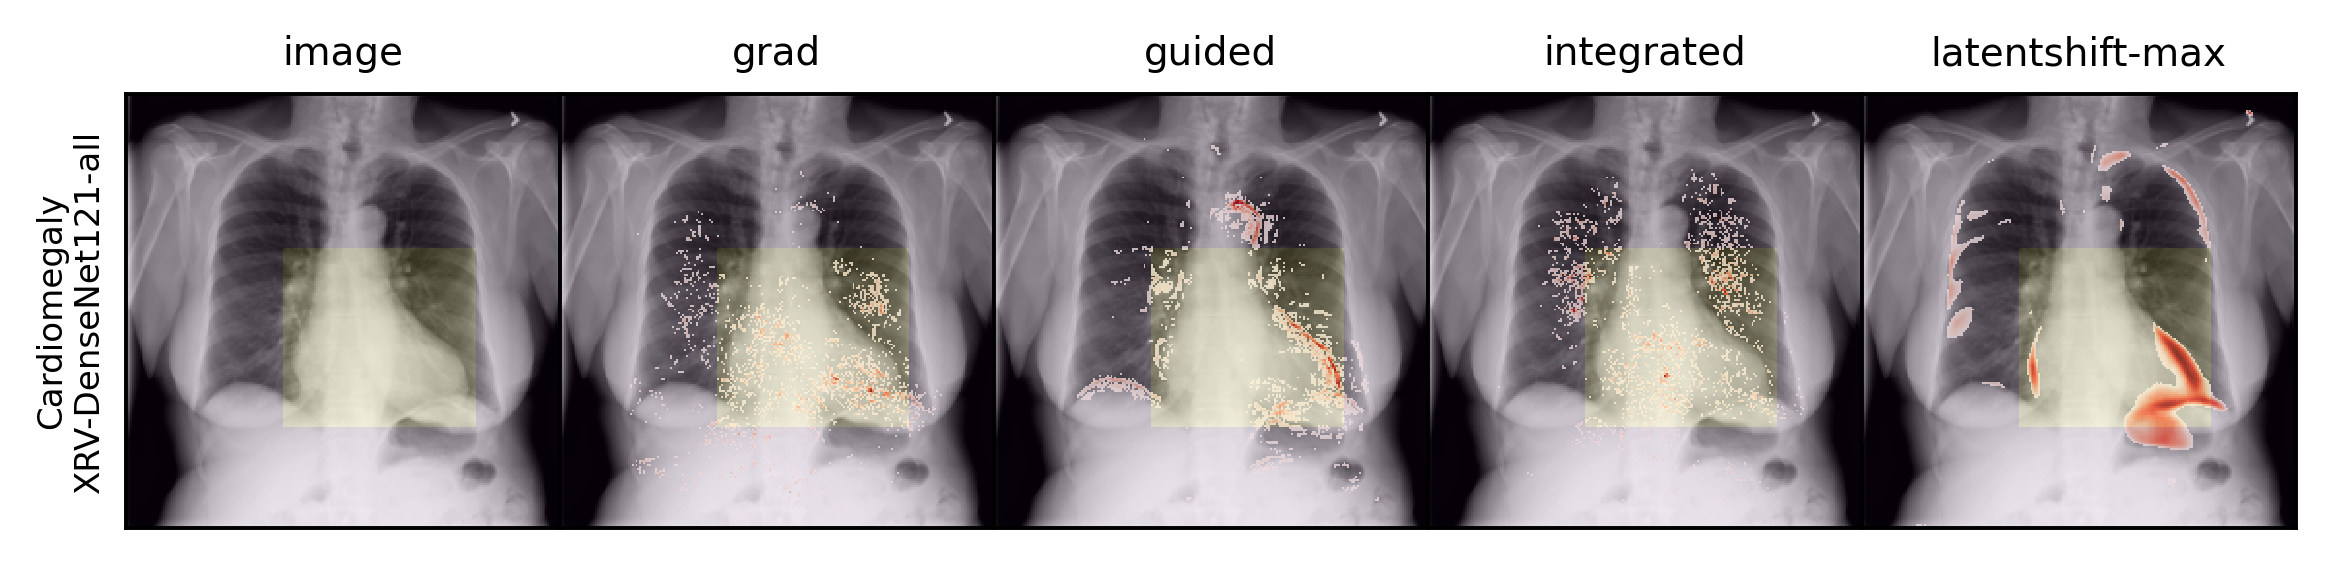

In [16]:
target = "Cardiomegaly"
label = 1
dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
idx = 5
sample = dmerge[dwhere[idx]]
model = models[0]
saliency_map=attribution.generate_attributions(sample, model, target, ae, temp_path, dmerge)

In [51]:
demo_batch = [dmerge[each] for each in dwhere[:6]]

In [133]:
layers_to_randomize=['classifier',
                     'features.norm5',
                     'features.denseblock4', 
                     'features.transition3', 
                     'features.denseblock3',
                     'features.transition2', 
                     'features.denseblock2',
                     'features.transition1', 
                     'features.denseblock1',
                     'features.norm0',
                     'features.conv0'
                    ]

In [134]:
print(len(demo_batch))
master_cascading_randomization_dictionary = {} # key will be layer name.

densenet_model = ModelWrapper(models_toreset[0])
# reset the params
densenet_model.model.load_state_dict(model.state_dict())
# start without randomization
output_of_original_model = []
for current_sample in demo_batch:
    image = torch.from_numpy(current_sample["img"]).unsqueeze(0).cuda()
    saliency_maps = {}
    for method in methods:
        saliency_maps[method]=attribution.compute_attribution(image, method, densenet_model.model, target, ae=ae, take_abs=False, threshold=False)
    output_of_original_model.append( saliency_maps ) 
master_cascading_randomization_dictionary['Full'] = output_of_original_model

6
[0.6893909] -1000 510
[0.6280689] -1000 390
[0.3914846] -110 20
[0.71163327] -880 120
[0.5574434] -810 220
[0.44826764] -370 20


In [135]:
# begin randomization
for i, layer in enumerate(layers_to_randomize):
    print("Cascading reinitialization up to on layer {}".format(layer))
        
    # reinitialize a particular layer,
    # !!!!! all previously re-initialized are kept as is: not sure if this is a good idea !!!!!
    #
    densenet_model.reinit_layer_by_key(layer)
        
    # list to store collection of images
    list_of_random_mask_per_layer = []
    for j, current_sample in enumerate(demo_batch):
        image = torch.from_numpy(current_sample["img"]).unsqueeze(0).cuda()
#         current_image = current_sample['img']
#         # print(i)
#         imglogits = densenet_model.predict(torch.from_numpy(np.expand_dims(current_image, 0)).cuda())[0]
        
#         prediction_class = imglogits.argmax() # this the output to explain.

        # set up params for each saliency method
            # set up params for each saliency method
        saliency_maps = {}
        for method in methods:
            saliency_maps[method]=attribution.compute_attribution(image, method, densenet_model.model, target, ae=ae, take_abs=False, threshold=False)
        list_of_random_mask_per_layer.append( saliency_maps )
        # now add the list of random masks to the dictionary
    master_cascading_randomization_dictionary[layer] = list_of_random_mask_per_layer
layer_list = ['Full'] + layers_to_randomize

Cascading reinitialization up to on layer classifier
[0.759828] -1000 1000
[0.7715242] -1000 1000
[0.7794337] -1000 1000
[0.7644544] -1000 1000
[0.761385] -750 1000
[0.77101576] -1000 1000
Cascading reinitialization up to on layer features.norm5
[0.85629106] -1000 1000
[0.90063655] -1000 1000
[0.9129301] -1000 1000
[0.87211514] -1000 890
[0.85201573] -300 1000
[0.88640636] -1000 1000
Cascading reinitialization up to on layer features.denseblock4
[0.7727202] -1000 1000
[0.78273565] -1000 1000
[0.79532546] -1000 1000
[0.76719314] -1000 1000
[0.76754886] -1000 1000
[0.7844204] -1000 1000
Cascading reinitialization up to on layer features.transition3
[0.7457458] -1000 1000
[0.7504969] -1000 1000
[0.74613845] -1000 1000
[0.74657375] -1000 1000
[0.74523616] -1000 1000
[0.74905604] -1000 1000
Cascading reinitialization up to on layer features.denseblock3
[0.74225295] -1000 1000
[0.7456002] -1000 1000
[0.7446552] -1000 1000
[0.74371994] -1000 1000
[0.7426832] -1000 1000
[0.7455803] -1000 1000


In [136]:
master_cascading_randomization_dictionary_abs_norm = {}
master_cascading_randomization_dictionary_no_abs_norm = {}
master_cascading_randomization_dictionary_0_1_norm = {}

for layer_index, layer_output in master_cascading_randomization_dictionary.items():
    mask_list_abs_norm = []
    mask_list_no_abs_norm = []
    mask_list_0_1_norm = []
    for i, mask_dict in enumerate(layer_output):
    # first append original image
        new_dict_abs_norm = {}
        new_dict_no_abs_norm = {}
        new_dict_0_1_norm = {}
        for key in mask_dict:
            mask = mask_dict[key]
            
            mask_abs_norm = abs_grayscale_norm(mask)
            mask_no_abs_norm = diverging_norm(mask)
            mask_0_1_norm = normalize_image(mask)
            
            new_dict_abs_norm[key] = mask_abs_norm
            new_dict_no_abs_norm[key] = mask_no_abs_norm
            new_dict_0_1_norm[key] = mask_0_1_norm
            
        mask_list_abs_norm.append(new_dict_abs_norm)
        mask_list_no_abs_norm.append(new_dict_no_abs_norm)
        mask_list_0_1_norm.append(new_dict_0_1_norm)
    master_cascading_randomization_dictionary_abs_norm[layer_index] = mask_list_abs_norm
    master_cascading_randomization_dictionary_no_abs_norm[layer_index] = mask_list_no_abs_norm
    master_cascading_randomization_dictionary_0_1_norm[layer_index] = mask_list_0_1_norm

In [137]:
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_no_abs_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_no_abs_norm[key][i])
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_abs_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_abs_norm[key][i])
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_0_1_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_0_1_norm[key][i])

# Visualizing Cascading Randomization

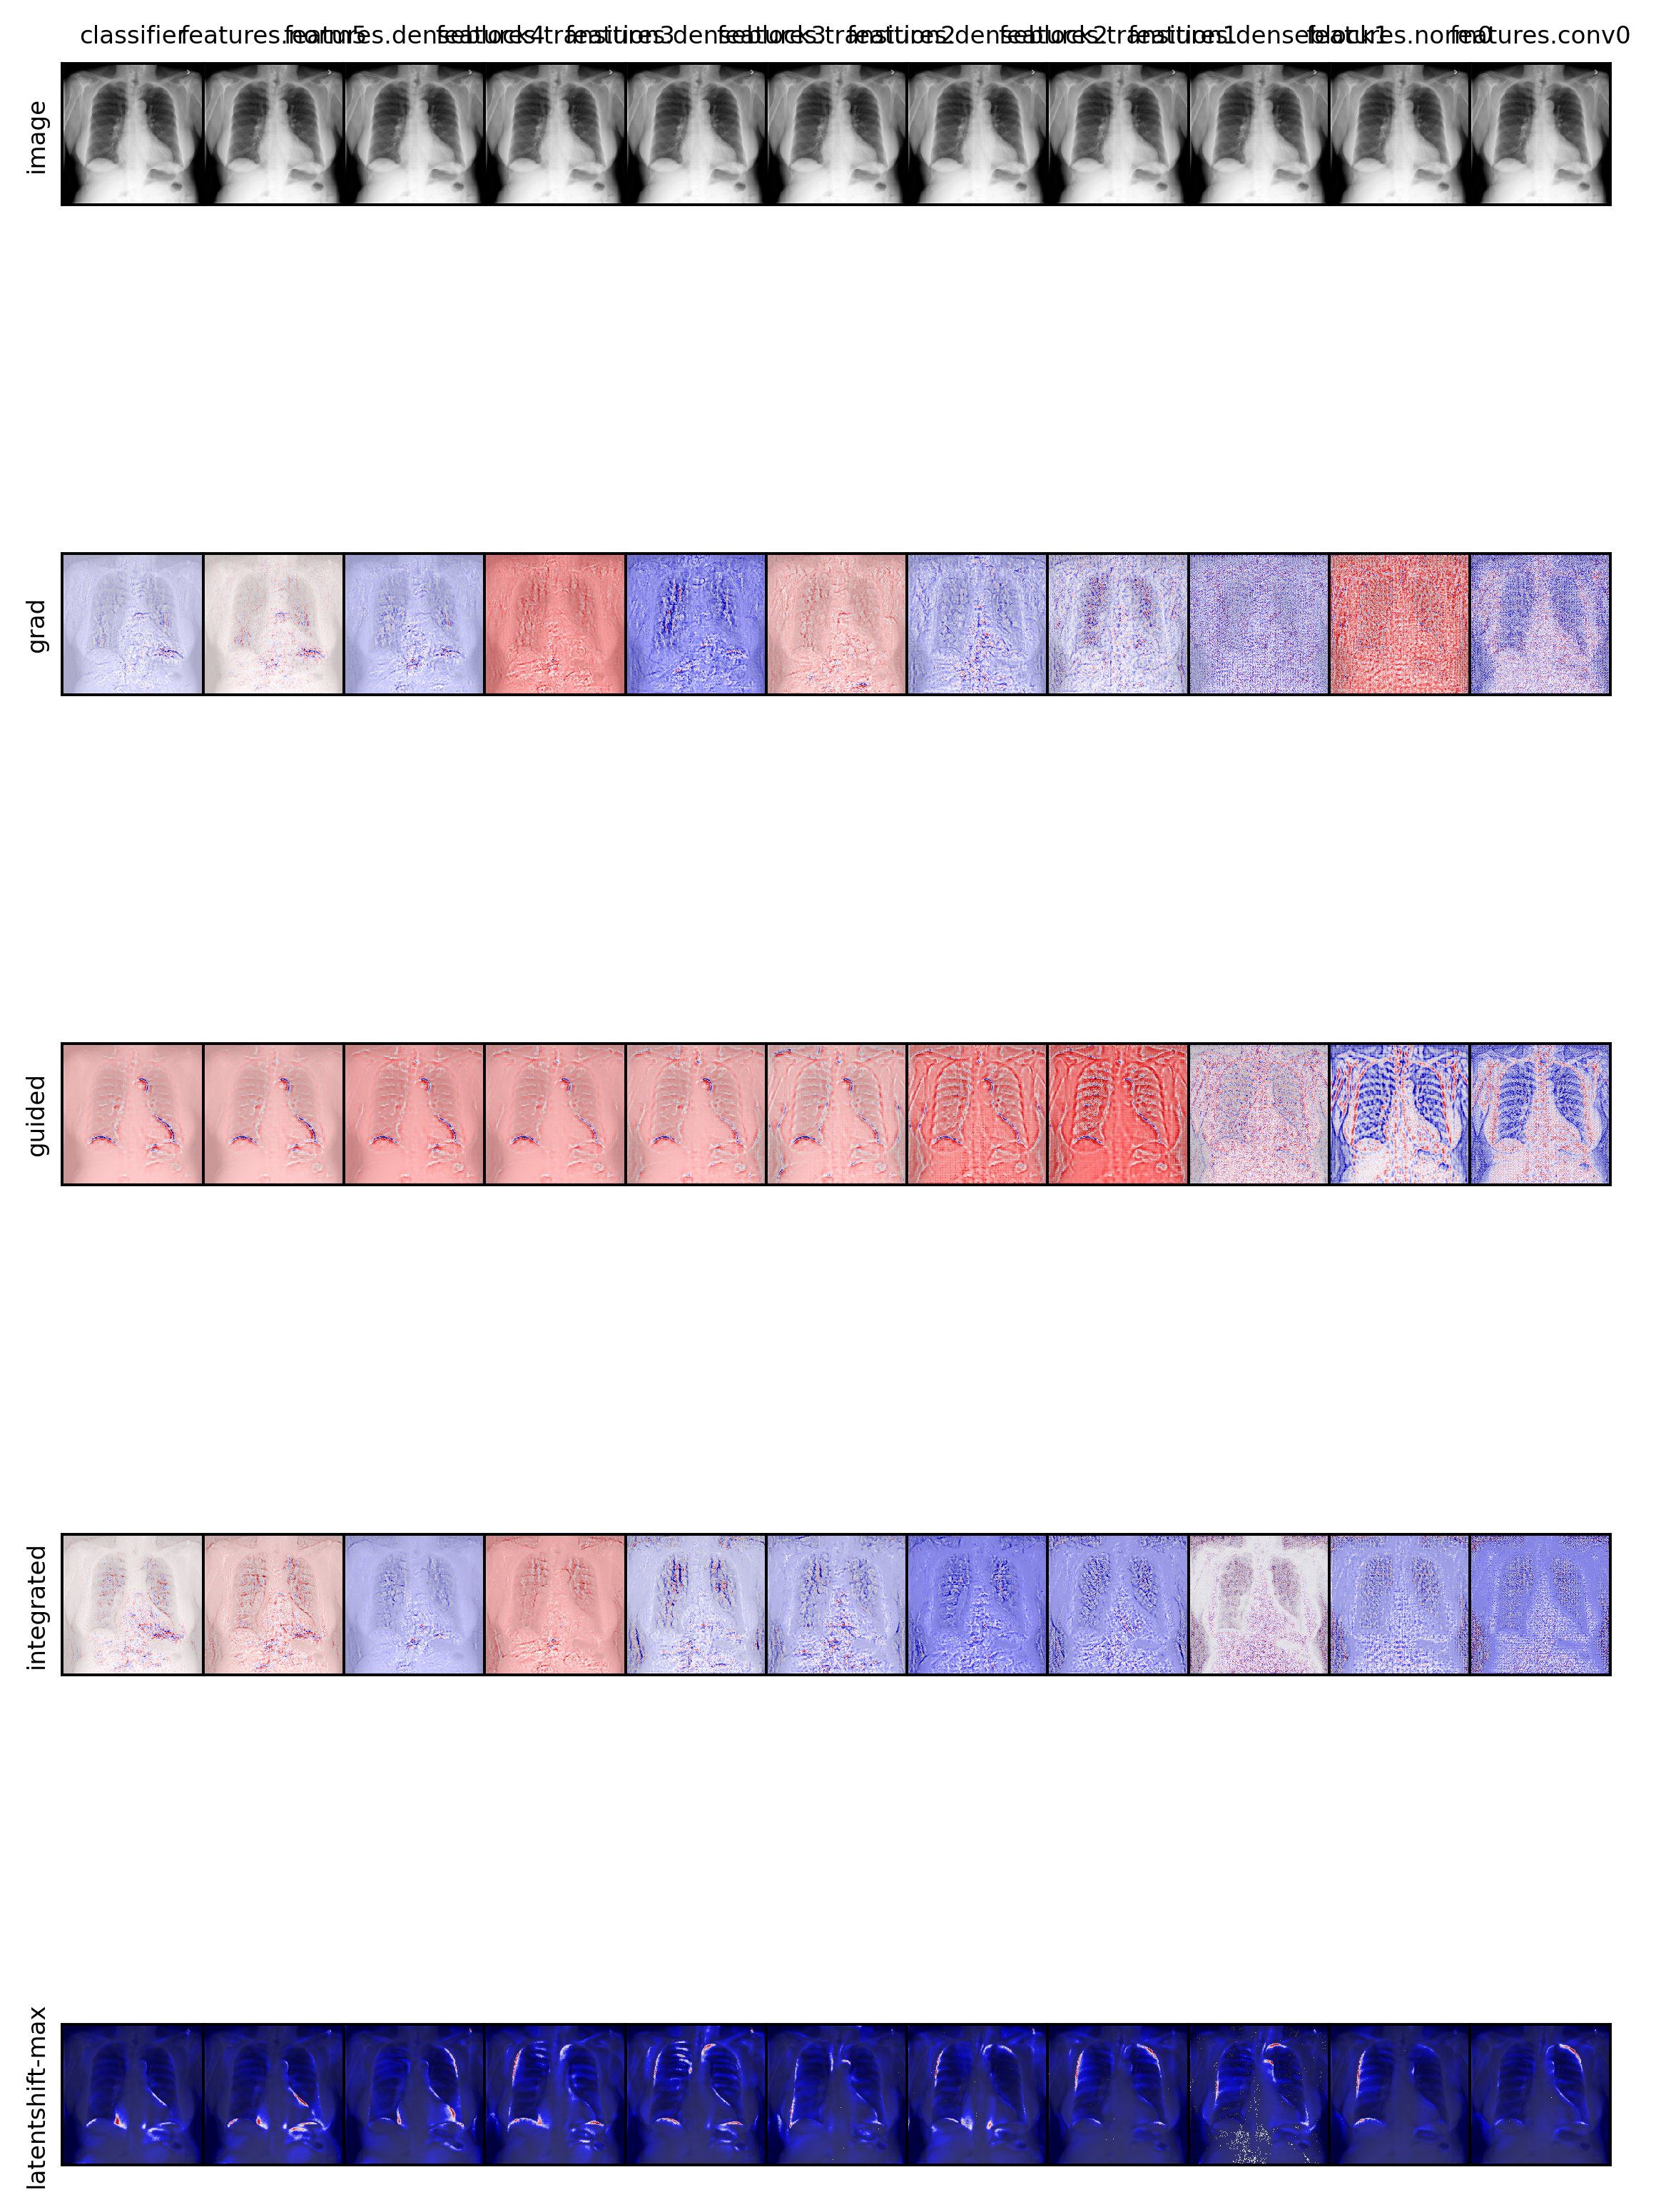

In [138]:
index_to_input_to_plot = -1 # this must be less than the len of demo_batch
current_sample = demo_batch[index_to_input_to_plot]
image = torch.from_numpy(current_sample["img"]).unsqueeze(0).detach().cpu()[0][0]
fig, ax = plt.subplots(len(methods) + 1, len(layers_to_randomize), figsize=(8,3*len(methods)+1), dpi=350)
for i, method in enumerate(['image'] + methods):
    for j, layer in enumerate(layers_to_randomize):
        if method == "image":
            ax[i][j].imshow(image, interpolation='none', cmap="gray")
            ax[i][j].set_title(layer, fontsize=7)
        else:
            dimage = master_cascading_randomization_dictionary[layer][index_to_input_to_plot][method].copy()
            ax[i][j].imshow(image, interpolation='none', cmap="gray")
            dimage[dimage==0] = np.nan
            ax[i][j].imshow(dimage, interpolation='none', alpha=0.8, cmap="seismic");
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].set_yticks([])
        #ax[i].get_yaxis().set_visible(False)
        if j==0:
            ax[i][j].set_ylabel(method, fontsize=7)
fig.subplots_adjust(wspace=0, hspace=0);
plt.show()


In [139]:
layers=list(master_cascading_randomization_dictionary_abs_norm.keys())
methods_list = list(master_cascading_randomization_dictionary_abs_norm[layers[0]][0].keys())

# dictionary to save all of the metrics.
rank_correlation_dictionary_abs_norm = {}
rank_correlation_dictionary_no_abs_norm = {}
ssim_dictionary_0_1_norm = {}
hog_dictionary_0_1_norm = {}

# initialize the dictionaries appropriately.
for layer in layers[1:]:
    rank_correlation_dictionary_abs_norm[layer] = {}
    rank_correlation_dictionary_no_abs_norm[layer] = {}
    ssim_dictionary_0_1_norm[layer] = {}
    hog_dictionary_0_1_norm[layer] = {}
    for method in methods_list:
        rank_correlation_dictionary_abs_norm[layer][method] = []
        rank_correlation_dictionary_no_abs_norm[layer][method] = []
        ssim_dictionary_0_1_norm[layer][method] = []
        hog_dictionary_0_1_norm[layer][method] = []
        
for layer in layers:
    if layer == layers[0]: 
        continue
    for i, mask_dict in enumerate(master_cascading_randomization_dictionary_abs_norm[layer]):
        for method in methods_list:
            normal_mask_abs_norm = master_cascading_randomization_dictionary_abs_norm[layers[0]][i][method]
            normal_mask_no_abs_norm = master_cascading_randomization_dictionary_no_abs_norm[layers[0]][i][method]
            normal_mask_0_1_norm = master_cascading_randomization_dictionary_0_1_norm[layers[0]][i][method]
            
            
            rand_mask_abs_norm = mask_dict[method]
            rand_mask_no_abs_norm = master_cascading_randomization_dictionary_no_abs_norm[layer][i][method]
            rand_mask_0_1_norm = master_cascading_randomization_dictionary_0_1_norm[layer][i][method]
            
            # compute rank correlation
            rk_abs_abs_value_norm, _ = spr(normal_mask_abs_norm.flatten(), rand_mask_abs_norm.flatten())
            rk_no_abs_value_norm, _ = spr(normal_mask_no_abs_norm.flatten(), rand_mask_no_abs_norm.flatten())
            
            # compute ssim
            ss1 = structural_similarity(normal_mask_0_1_norm, rand_mask_0_1_norm,
                       gaussian_weights=True, multichannel=True)
            
            # rank correlation between histogram of gradients
            normal_hog = feature.hog(normal_mask_0_1_norm,
                                     pixels_per_cell=(16, 16))
            rand_hog = feature.hog(rand_mask_0_1_norm,
                                   pixels_per_cell=(16, 16))
            rank_corr_hog = spr(normal_hog, rand_hog)[0]
            
            # collate all the values into their respective dictionaries.
            rank_correlation_dictionary_abs_norm[layer][method].append(rk_abs_abs_value_norm)
            rank_correlation_dictionary_no_abs_norm[layer][method].append(rk_no_abs_value_norm)
            ssim_dictionary_0_1_norm[layer][method].append(ss1)
            hog_dictionary_0_1_norm[layer][method].append(rank_corr_hog)

In [140]:
methods_list = list(master_cascading_randomization_dictionary_abs_norm[layers[0]][0].keys())

# dictionary to save all of the metrics.
metric_output=[]
        
for l,layer in enumerate(layers):
    #if l == 0: 
    #    continue
    layer_name="%02d %s"%(l,layer.split('.')[-1])
    for i in range(len(master_cascading_randomization_dictionary_abs_norm[layer])):
        for method in methods_list:
            normal_mask_abs_norm = master_cascading_randomization_dictionary_abs_norm[layers[0]][i][method]
            normal_mask_no_abs_norm = master_cascading_randomization_dictionary_no_abs_norm[layers[0]][i][method]
            normal_mask_0_1_norm = master_cascading_randomization_dictionary_0_1_norm[layers[0]][i][method]
            
            
            rand_mask_abs_norm = master_cascading_randomization_dictionary_abs_norm[layer][i][method]
            rand_mask_no_abs_norm = master_cascading_randomization_dictionary_no_abs_norm[layer][i][method]
            rand_mask_0_1_norm = master_cascading_randomization_dictionary_0_1_norm[layer][i][method]
            
            # compute rank correlation
            rk_abs_abs_value_norm, _ = spr(normal_mask_abs_norm.flatten(), rand_mask_abs_norm.flatten())
            rk_no_abs_value_norm, _ = spr(normal_mask_no_abs_norm.flatten(), rand_mask_no_abs_norm.flatten())
            
            # compute ssim
            ss1 = structural_similarity(normal_mask_0_1_norm, rand_mask_0_1_norm,
                       gaussian_weights=True, multichannel=True)
            
            # rank correlation between histogram of gradients
            normal_hog = feature.hog(normal_mask_0_1_norm,
                                     pixels_per_cell=(16, 16))
            rand_hog = feature.hog(rand_mask_0_1_norm,
                                   pixels_per_cell=(16, 16))
            rank_corr_hog = spr(normal_hog, rand_hog)[0]
            
            metric_output.append({
                'layer': layer_name,
                'image': i,
                'method': method,
                'spearman_abs': rk_abs_abs_value_norm,
                'spearman': rk_no_abs_value_norm,
                'ssim': ss1,
                'hog spearman': rank_corr_hog,
            })


In [141]:
metrics_df=pd.DataFrame(metric_output)

In [142]:
df = metrics_df.groupby(by=['layer','method']).mean()
display(df)

image  spearman_abs  spearman      ssim  \
layer          method                                                     
00 Full        grad               2.5      1.000000  1.000000  1.000000   
               guided             2.5      1.000000  1.000000  1.000000   
               integrated         2.5      1.000000  1.000000  1.000000   
               latentshift-max    2.5      1.000000  1.000000  1.000000   
01 classifier  grad               2.5      0.578416 -0.086879  0.856278   
               guided             2.5      0.952974  0.983577  0.989759   
               integrated         2.5      0.653062 -0.020153  0.876263   
               latentshift-max    2.5      0.330284  0.330284  0.613094   
02 norm5       grad               2.5      0.556769  0.012881  0.860527   
               guided             2.5      0.932261  0.978384  0.986798   
               integrated         2.5      0.645307  0.059743  0.888605   
               latentshift-max    2.5      0.343476  0.343476  0.622996   
03 denseblock4 grad               2.5      0.489591 -0.104824  0.820656   
               guided             2.5      0.838021  0.953116  0.972886   
               integrated         2.5      0.608824 -0.192703  0.834430   
               latentshift-max    2.5      0.364981  0.364981  0.631875   
04 transition3 grad               2.5      0.387809  0.110342  0.800773   
               guided             2.5      0.815523  0.948414  0.972892   
               integrated         2.5      0.504246  0.120662  0.846953   
               latentshift-max    2.5      0.350570  0.350570  0.610196   
05 denseblock3 grad               2.5      0.358123  0.059047  0.745736   
               guided             2.5      0.716196  0.919989  0.951551   
               integrated         2.5      0.497567  0.048465  0.822348   
               latentshift-max    2.5      0.294788  0.294788  0.588725   
06 transition2 grad               2.5      0.314100 -0.016607  0.736985   
               guided             2.5      0.633888  0.885586  0.946093   
               integrated         2.5      0.479355 -0.027133  0.783393   
               latentshift-max    2.5      0.285091  0.285091  0.593180   
07 denseblock2 grad               2.5      0.305674  0.000679  0.716862   
               guided             2.5      0.539895  0.829346  0.857400   
               integrated         2.5      0.462173 -0.001116  0.780878   
               latentshift-max    2.5      0.228255  0.228255  0.591326   
08 transition1 grad               2.5      0.200709  0.036128  0.641810   
               guided             2.5      0.544307  0.816784  0.830650   
               integrated         2.5      0.439916  0.048281  0.754411   
               latentshift-max    2.5      0.310088  0.310088  0.594233   
09 denseblock1 grad               2.5      0.122194  0.049599  0.456985   
               guided             2.5      0.196885  0.441158  0.489445   
               integrated         2.5      0.342513  0.030746  0.657455   
               latentshift-max    2.5      0.249256  0.249256  0.550829   
10 norm0       grad               2.5      0.046177 -0.023587  0.429656   
               guided             2.5      0.358840  0.703863  0.681163   
               integrated         2.5      0.327632 -0.016059  0.680978   
               latentshift-max    2.5      0.267862  0.267862  0.555488   
11 conv0       grad               2.5      0.048840 -0.001486  0.389244   
               guided             2.5      0.171562  0.457740  0.515329   
               integrated         2.5      0.326308 -0.004854  0.646679   
               latentshift-max    2.5      0.285650  0.285650  0.587671   

                                hog spearman  
layer          method                         
00 Full        grad                 1.000000  
               guided               1.000000  
               integrated           1.000000  
               latentshift-max      1.000000  

Text(0.5, 1.0, 'Spearman correlation of saliency under cascading randomization')

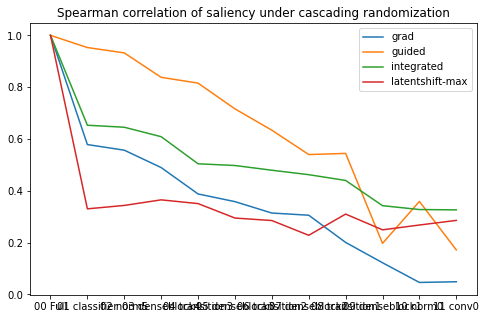

In [143]:
labels=df.reset_index()["layer"].drop_duplicates().to_list()
data=dict()
for method in methods:
    tmp=df.reset_index()
    data[method]=tmp.loc[tmp['method']==method]['spearman_abs'].values
fig=plt.figure(figsize=(8,5))
for k,v in data.items():
    plt.plot(v,label=k)
plt.xticks(range(len(v)),labels)
plt.legend()
#plt.ylabel("Spearman Correlation (abs)")
plt.title("Spearman correlation of saliency under cascading randomization")